Import the pandas library for the purpose of creating dataframes.

In [11]:
import pandas as pd

Upload a dataset containing information of geo-coordinates and year of observation for the Mountain Dogwood (cornus nuttalli).

In [12]:
mtdogwd = pd.read_csv('Desktop/biodata/0075163-200613084148143 - 0075163-200613084148143.csv')

In [13]:
mtdogwd

,decimalLatitude,decimalLongitude,year
0,42.278810,-123.826406,1984
1,47.037825,-123.006900,1936
2,38.910390,-76.966086,1980
3,36.494104,-118.579392,2004
4,48.674040,-121.268538,2013
...,...,...,...
386,45.501400,-123.253400,1922
387,45.371300,-122.862500,1967
388,44.075900,-123.114200,1963
389,43.977800,-123.140800,1963


Sort the file by year and then reset the index accordingly.

In [14]:
mtdogwd = mtdogwd.sort_values(by='year')


In [15]:
mtdogwd = mtdogwd.reset_index(drop=True)


In [16]:
mtdogwd

,decimalLatitude,decimalLongitude,year
0,45.351400,-122.620800,1899
1,44.499700,-123.416700,1900
2,45.540700,-122.708400,1902
3,45.528900,-122.720000,1903
4,42.439200,-123.327200,1909
...,...,...,...
386,37.740041,-119.609527,2013
387,36.702729,-118.920896,2013
388,38.083874,-120.194893,2013
389,37.480069,-119.632316,2013


Import libraries and create a function that will use the geo-coordinates to obtain elevation data for each geo-coordinate through the Open-Elevation API.

In [17]:
import json

In [18]:
import urllib

In [19]:
def elevation(df):
    #json
    d_ar=[{}]*len(df['decimalLatitude'])
    for i in range(len(df['decimalLatitude'][:])):
        d_ar[i]={"latitude":df['decimalLatitude'][i],"longitude":df['decimalLongitude'][i]}
    location={"locations":d_ar}
    json_data=json.dumps(location,skipkeys=int).encode('utf8')

    #SEND REQUEST
    url="https://api.open-elevation.com/api/v1/lookup"
    response = urllib.request.Request(url,json_data,headers={'Content-Type': 'application/json'})
    fp=urllib.request.urlopen(response)

    #RESPONSE PROCESSING
    res_byte=fp.read()
    res_str=res_byte.decode("utf8")
    js_str=json.loads(res_str)
    #print (js_mystr)
    fp.close()

    #GETTING ELEVATION
    response_len=len(js_str['results'])
    elev_list = []
    for j in range(response_len):
        elev_list.append(js_str['results'][j]['elevation'])
    df['elevation'] = elev_list
    return df

elevation(mtdogwd)

,decimalLatitude,decimalLongitude,year,elevation
0,45.351400,-122.620800,1899,7
1,44.499700,-123.416700,1900,252
2,45.540700,-122.708400,1902,12
3,45.528900,-122.720000,1903,242
4,42.439200,-123.327200,1909,288
...,...,...,...,...
386,37.740041,-119.609527,2013,1498
387,36.702729,-118.920896,2013,1998
388,38.083874,-120.194893,2013,1151
389,37.480069,-119.632316,2013,1603


Import statsmodels library and perform a power analysis to determine necessary sample size for a small effect size of at least .2 based on a standard significance of .05 and a power of .08.   This requires at least 199 observations.

In [191]:
from statsmodels.stats import power
nobs = power.tt_solve_power(
effect_size= .2, alpha =0.05, power=0.8 )
print (nobs)

198.1508243394218


Below are several tests for normality from the scipy and statsmodels libraries.  The data is not normally distributed, but with a sample size larger than 20-30 a power analysis is robust to non-normality and linear regressions do not require normality.

In [18]:
from scipy.stats import normaltest
k2, p = normaltest(mtdogwd['elevation'])
print(p)

0.003436126893677618


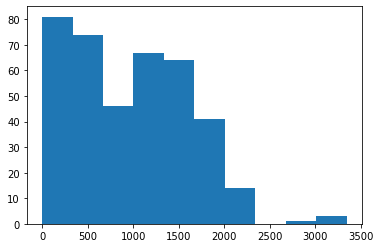

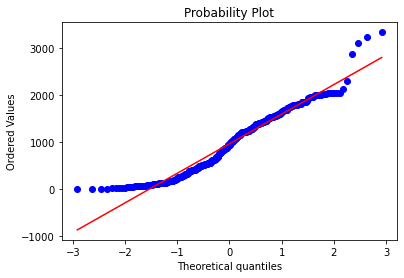

p-values for all 391 data points: ----------------
Omnibus               3.436127e-03
Shapiro-Wilk          6.852133e-10
Lilliefors            1.000000e-03
Kolmogorov-Smirnov    2.043427e-03
dtype: float64
p-values for the first 100 data points: ----------------
Omnibus               1.974113e-03
Shapiro-Wilk          2.044461e-07
Lilliefors            1.000000e-03
Kolmogorov-Smirnov    1.020673e-03
dtype: float64


<ipython-input-23-017709124013>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pVals = pd.Series()
<ipython-input-23-017709124013>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pFewVals = pd.Series()


In [23]:
from statsmodels.stats.diagnostic import lilliefors
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
# Set the parameters
#numData = len(df_elev) 
#myMean = np.mean(df_elev)
#mySD = np.std(df_elev)
    
    # To get reproducable values, I provide a seed value
    #np.random.seed(1234)   
    
    # Generate and show random data
data = mtdogwd['elevation']
#stats.norm.rvs(df_elev)
fewData = data[:100]
plt.hist(data)
plt.show()

    # --- >>> START stats <<< ---
    # Graphical test: if the data lie on a line, they are pretty much
    # normally distributed
_ = stats.probplot(mtdogwd['elevation'], plot=plt)
plt.show()

pVals = pd.Series()
pFewVals = pd.Series()
    # The scipy normaltest is based on D-Agostino and Pearsons test that
    # combines skew and kurtosis to produce an omnibus test of normality.
_, pVals['Omnibus']    = stats.normaltest(data)
_, pFewVals['Omnibus'] = stats.normaltest(fewData)

    # Shapiro-Wilk test
_, pVals['Shapiro-Wilk']    = stats.shapiro(data)
_, pFewVals['Shapiro-Wilk'] = stats.shapiro(fewData)
    
    # Or you can check for normality with Lilliefors-test
_, pVals['Lilliefors']    = lilliefors(data)
_, pFewVals['Lilliefors'] = lilliefors(fewData)
    
    # Alternatively with original Kolmogorov-Smirnov test
_, pVals['Kolmogorov-Smirnov']    = stats.kstest((data-np.mean(data))/np.std(data,ddof=1), 'norm')
_, pFewVals['Kolmogorov-Smirnov'] = stats.kstest((fewData-np.mean(fewData))/np.std(fewData,ddof=1), 'norm')
    
print('p-values for all {0} data points: ----------------'.format(len(data)))
print(pVals)
print('p-values for the first 100 data points: ----------------')
print(pFewVals)
    
if pVals['Omnibus'] > 0.05:
    print('Data are normally distributed')

Performing a natural logarithm transformation of the data is often recommended in cases of positive data with skewness (like the elevation data). Some other possible transformations are: reciprocal x: (1/x), square root x: x ** (1/2), and cube root x: x ** (1/3) 

In [30]:
elev_log = mtdogwd['elevation'].apply(lambda x: np.log(x+ 1))
elev_log.dropna()

0      2.079442
1      5.533389
2      2.564949
3      5.493061
4      5.666427
         ...   
386    7.312553
387    7.600402
388    7.049255
389    7.380256
390    7.193686
Name: elevation, Length: 391, dtype: float64

Clean and test the transformed data for normality, then plot a histrogram.

4.618016089373011e-31


(array([  1.,   0.,   1.,   4.,   7.,  25.,  36.,  81., 144.,  92.]),
 array([0.        , 0.81155209, 1.62310418, 2.43465626, 3.24620835,
        4.05776044, 4.86931253, 5.68086462, 6.49241671, 7.30396879,
        8.11552088]),
 <BarContainer object of 10 artists>)

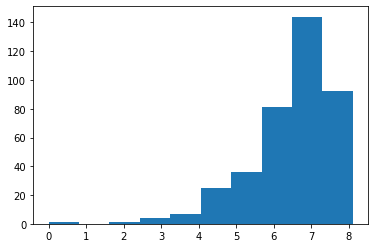

In [31]:
elev_log.replace([np.inf, -np.inf], np.nan, inplace=True) 
  
# Dropping all the rows with nan values 
elev_log.dropna(inplace=True) 

elev_log = elev_log.tolist() 

from scipy.stats import normaltest
k2, p = normaltest(elev_log)
print(p)
plt.hist(elev_log)

In [32]:
mtdogwd['elevation ln'] = elev_log

mtdogwd

,decimalLatitude,decimalLongitude,year,elevation,elevation ln
0,45.351400,-122.620800,1899,7,2.079442
1,44.499700,-123.416700,1900,252,5.533389
2,45.540700,-122.708400,1902,12,2.564949
3,45.528900,-122.720000,1903,242,5.493061
4,42.439200,-123.327200,1909,288,5.666427
...,...,...,...,...,...
386,37.740041,-119.609527,2013,1498,7.312553
387,36.702729,-118.920896,2013,1998,7.600402
388,38.083874,-120.194893,2013,1151,7.049255
389,37.480069,-119.632316,2013,1603,7.380256


Creat a function for performing regression analysis on log transformed elevation data.

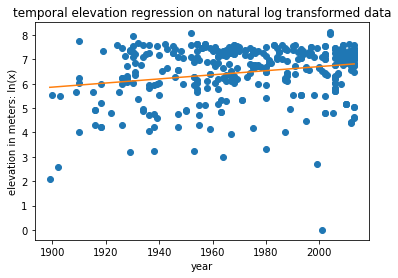

In [33]:
def elevlogreg(df):
    x = df['year']
    plt.plot(df['year'], df['elevation ln'], 'o')
    m, b = np.polyfit(df['year'], df['elevation ln'], 1)
    plt.title('temporal elevation regression on natural log transformed data')
    plt.xlabel('year')
    plt.ylabel('elevation in meters: ln(x)')
    return plt.plot(x, m*x+b)
    
elevlogreg(mtdogwd)

Obtain some values and a summary report of the regression.

In [34]:
stats.linregress(x= mtdogwd['year'], y = mtdogwd['elevation ln'])


LinregressResult(slope=0.0084312996835037, intercept=-10.157026754469452, rvalue=0.23120910889977986, pvalue=3.837869885854933e-06, stderr=0.0017988079988688957)

In [35]:
y = mtdogwd['elevation ln']
x = mtdogwd['year']


import statsmodels.formula.api as sm
mtdogwdmodel = sm.ols('y~x', data=mtdogwd).fit()
print( mtdogwdmodel.summary() )

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     21.97
Date:                Fri, 13 Nov 2020   Prob (F-statistic):           3.84e-06
Time:                        13:44:11   Log-Likelihood:                -581.90
No. Observations:                 391   AIC:                             1168.
Df Residuals:                     389   BIC:                             1176.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.1570      3.554     -2.858      0.0

Create function that brings up a diagnostic residual plot in order to check for heteroscedasticity and non-linearity in the regression.

<AxesSubplot:title={'center':'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

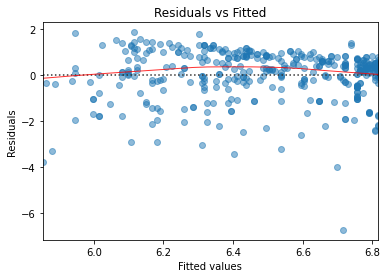

In [45]:
#model_fitted_y = model.fittedvalues
# model residuals
#model_residuals = model.resid
# normalized residuals
#model_norm_residuals = model.get_influence().resid_studentized_internal
# absolute squared normalized residuals
#model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
#model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
#model_leverage = model.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
#model_cooks = model.get_influence().cooks_distance[0]
import seaborn as sns
def residualplot(model):
    plot_lm_1 = plt.figure()
    plot_lm_1.axes[0] = sns.residplot(x=model.fittedvalues, y=model.resid,
                              lowess=True,
                              scatter_kws={'alpha': 0.5},
                              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals')
    return plot_lm_1.axes[0]

residualplot(mtdogwdmodel)

Create a function to perform linear regression on non-transformed elevation data in order to determine if there is a temporal trend in the elevation of observations for the Mountain Dogwood.

The results of the linear regression indicate a rise of approx. 377 meters over approx. a century of observation.

Average elevation in 1899: 717.4105327015495 meters
Average elevation in 2013: 1094.3157947860964 meters
Change of 376.90526208454685 meters


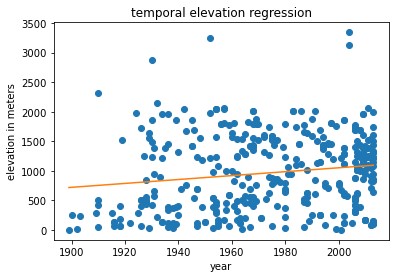

In [36]:
def elevationreg(df):
    x = df['year']
    plt.plot(df['year'], df['elevation'], 'o')
    m, b = np.polyfit(df['year'], df['elevation'], 1)
    plt.title('temporal elevation regression')
    plt.xlabel('year')
    plt.ylabel('elevation in meters')
    print ('Average elevation in {}: {} meters'.format(df.loc[0,'year'],(m*df.loc[0,'year'] + b)))
    print ('Average elevation in {}: {} meters'.format(df.year.iloc[-1],(m*df.year.iloc[-1] + b)))
    print ('Change of {} meters'.format((m*df.year.iloc[-1] + b)- (m*df.loc[0,'year'] + b)))
    return plt.plot(x, m*x+b)
    
elevationreg(mtdogwd)

Get summary of regression results.

In [47]:

y = mtdogwd['elevation']
x = mtdogwd['year']


mtdogwdmodelorig = sm.ols('y~x', data=mtdogwd).fit()
print( mtdogwdmodelorig.summary() )

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     9.683
Date:                Thu, 12 Nov 2020   Prob (F-statistic):            0.00200
Time:                        11:08:55   Log-Likelihood:                -3077.0
No. Observations:                 391   AIC:                             6158.
Df Residuals:                     389   BIC:                             6166.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5561.0376   2098.937     -2.649      0.0

Create another diagnostic plot.  Comparing this to the diagnostic plot for previous transformed data, the transformation doesn't appear to reduce heteroscedasticity or much non-linearity.

<AxesSubplot:title={'center':'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

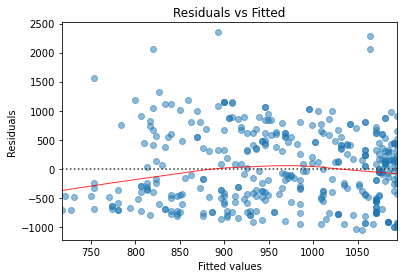

In [48]:
residualplot(mtdogwdmodelorig)

It's possible that this finding is confounded by other variables. One possibility is latitude (other possibilities outside the domain of this analysis include moisture levels, pathogens and geographic peculiarities e.g. the southern portion of a mountain range may have higher elevations allowing for more specimen observations of alpine species in the southern region). There may also be issues of sampling bias (the lower left portion of the latitudinal regression corresponding to more southerly observations before the 1920s seems to have a suspicious lack of data). We run a linear regression upon changes in latitude over the approx. century of observation. We find there has been a southward shift of approx. 2 degrees of latitude.

Normality test and histogram plot for latitude data.

1.2398461125576244e-11


<AxesSubplot:xlabel='decimalLatitude', ylabel='Count'>

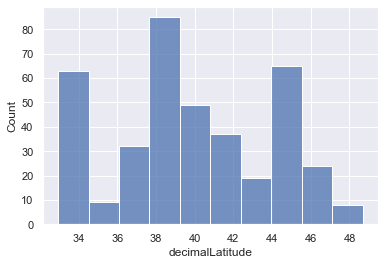

In [206]:
from scipy.stats import normaltest
k2, p = normaltest(sorted_dfyr['decimalLatitude'])
print(p)
sns.histplot(sorted_dfyr['decimalLatitude'])

Create a function for performing regression on latitude data.

Average latitude in 1899: 41.23595448193527 
Average latitude in 2013: 39.22072480489157 


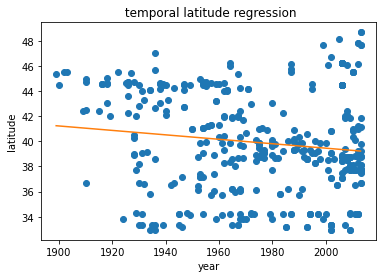

In [68]:
def latreg(df):
    x = df['year']
    plt.plot(df['year'], df['decimalLatitude'], 'o')
    m, b = np.polyfit(df['year'], df['decimalLatitude'], 1)
    plt.title(' temporal latitude regression')
    plt.xlabel('year')
    plt.ylabel('latitude')
    print ('Average latitude in {}: {} '.format(df.loc[0,'year'],(m*df.loc[0,'year'] + b)))
    print ('Average latitude in {}: {} '.format(df.year.iloc[-1],(m*df.year.iloc[-1] + b)))
    #print ('Change of {} '.format((m*df.year.iloc[-1] + b)- (m*df.loc[0,'year'] + b)))
    return plt.plot(x, m*x+b)
latreg(mtdogwd)

The regression obtains a p level below alpha of .05 which grants this finding statistical significance.

In [46]:

stats.linregress(x= sorted_dfyr['year'], y = sorted_dfyr['decimalLatitude'])

LinregressResult(slope=-0.017677453307400937, intercept=74.80543831268966, rvalue=-0.1339874979837837, pvalue=0.007979854966857325, stderr=0.006628981925000532)



Is a southward shift of 2 degrees sufficient to explain the rise in elevation? The average treeline in the North Cascades is at approx. 1800 meters of elevation. In the Sierra Nevadas the treeline on average is found at approx. 3000 meters. This is a decline of 1200 meters as we head approx. 10 degrees further north in latitude, or about 120 meters per degree of latitude. It would seem the rise in elevation is confounded partially by the southward shift of the Mountain Dogwood.


Create a function to run another regression based on our specific species data to see how elevation relates to latitude.

Average elevation in Sierra Nevadas(37 degrees of latitude): 1278.4593751827324 meters
Average elevation in Cascades(47 degrees of latitude): 208.77692077522352 meters
Average change per degree of latitude: -106.96824544075089 meters


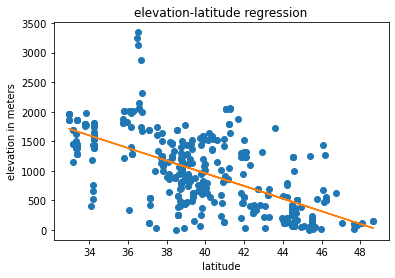

In [70]:
def elevlatreg(df):
    x = df['decimalLatitude']
    plt.plot(df['decimalLatitude'], df['elevation'], 'o')
    m, b = np.polyfit(df['decimalLatitude'], df['elevation'], 1)
    plt.title('elevation-latitude regression')
    plt.xlabel('latitude')
    plt.ylabel('elevation in meters')
    print ('Average elevation in Sierra Nevadas(37 degrees of latitude): {} meters'.format(m*37+b))
    print ('Average elevation in Cascades(47 degrees of latitude): {} meters'.format(m*47 + b))
    print ('Average change per degree of latitude: {} meters'.format(((m*47+b)-(m*37+b))/10 ))
    return plt.plot(x, m*x+b)
elevlatreg(mtdogwd)

Run a regression analysis on the Whitebark Pine (pinus albicaulis):

In [5]:
wbpine = pd.read_csv('Desktop/biodata/0077546-200613084148143 - 0077546-200613084148143.csv')

In [6]:
wbpine

,decimalLatitude,decimalLongitude,elevation,eventDate,year
0,40.479957,-121.503473,NaN,2007-08-07T09:00:00,2007
1,39.315063,-119.885506,NaN,2008-02-18T08:00:00,2008
2,43.749949,-110.079905,NaN,2004-01-21T09:50:00,2004
3,41.027222,-115.085000,2545.00,2004-07-28T00:00:00,2004
4,41.027222,-115.085000,2545.00,2004-07-28T00:00:00,2004
...,...,...,...,...,...
266,42.600000,-120.200000,NaN,1936-07-05T00:00:00,1936
267,44.300000,-121.800000,NaN,1934-06-10T00:00:00,1934
268,44.600000,-118.600000,2377.44,1925-07-25T00:00:00,1925
269,43.500000,-122.100000,NaN,1932-07-04T00:00:00,1932


Sort the data temporally:

In [7]:
wbpine = wbpine.sort_values(by='eventDate')


In [8]:
wbpine = wbpine.reset_index(drop=True)


In [9]:
wbpine

,decimalLatitude,decimalLongitude,elevation,eventDate,year
0,46.033730,-121.492740,1982.0,1892-08-03T00:00:00,1892
1,45.500000,-111.330000,2150.0,1897-07-28T00:00:00,1897
2,37.843810,-119.421830,NaN,1898-08-07T00:00:00,1898
3,41.369300,-122.349800,1905.0,1899-08-01T00:00:00,1899
4,41.316600,-122.486700,NaN,1899-08-01T00:00:00,1899
...,...,...,...,...,...
266,44.282600,-118.707330,2419.0,2010-07-16T00:00:00,2010
267,43.706387,-121.235712,NaN,2010-07-16T11:51:00,2010
268,44.575610,-118.625310,2232.0,2010-07-17T00:00:00,2010
269,44.332403,-118.807523,1894.0,2010-07-18T00:00:00,2010


In [20]:
elevation(wbpine)

,decimalLatitude,decimalLongitude,elevation,eventDate,year
0,46.033730,-121.492740,758,1892-08-03T00:00:00,1892
1,45.500000,-111.330000,1742,1897-07-28T00:00:00,1897
2,37.843810,-119.421830,2838,1898-08-07T00:00:00,1898
3,41.369300,-122.349800,1744,1899-08-01T00:00:00,1899
4,41.316600,-122.486700,2460,1899-08-01T00:00:00,1899
...,...,...,...,...,...
266,44.282600,-118.707330,2407,2010-07-16T00:00:00,2010
267,43.706387,-121.235712,1945,2010-07-16T11:51:00,2010
268,44.575610,-118.625310,2135,2010-07-17T00:00:00,2010
269,44.332403,-118.807523,1938,2010-07-18T00:00:00,2010


Run regression analyses again on elevation and latitude.  This time both results show a trend toward colder climates, indicating that the Whitebark Pine may be a better candidate of a species impacted by globally rising temperatures.

Average elevation in 1892: 2097.737106165431 meters
Average elevation in 2010: 2532.213879272137 meters
Change of 434.4767731067059 meters


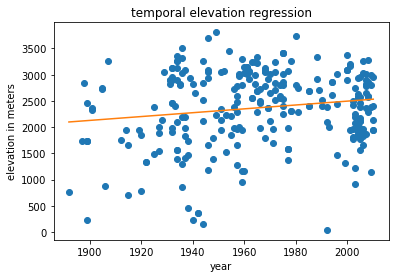

In [24]:
elevationreg(wbpine)

Below is a summary results table for the model, along with confidence intervals and a plot of the regression.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     6.859
Date:                Thu, 12 Nov 2020   Prob (F-statistic):            0.00932
Time:                        12:10:54   Log-Likelihood:                -2165.3
No. Observations:                 271   AIC:                             4335.
Df Residuals:                     269   BIC:                             4342.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4868.6193   2763.446     -1.762      0.0

,0,1
Intercept,-10309.351639,572.113060
x,0.914018,6.449995


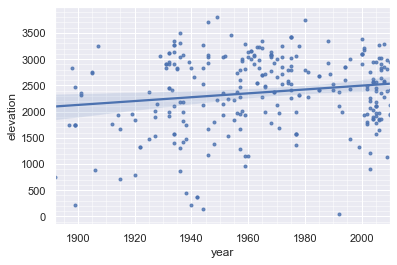

In [78]:
import matplotlib as mpl

sns.set(style="darkgrid")  
scatter_kws={"s": 1}

fig, ax = plt.subplots(1, 1)


sns.regplot(x = 'year', y ='elevation', data=wbpine, marker = '.', ci=95)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

y = wbpine['elevation']
x = wbpine['year']


wbpinemodel = sm.ols('y~x', data=wbpine).fit()
print( wbpinemodel.summary() )
wbpinemodel.conf_int()

A test for detecting heteroscedasticity with findings being significant:

In [79]:
from statsmodels.stats.diagnostic import het_white

white_test = het_white(wbpinemodel.resid,  wbpinemodel.model.exog)
white_test

(8.794003880460997,
 0.012314203333680652,
 4.494163129071027,
 0.01202890114157255)

Plot to visually inspect the residuals.  The bow-shaped curve indicates there may be some non-linearity in our model:

<AxesSubplot:title={'center':'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

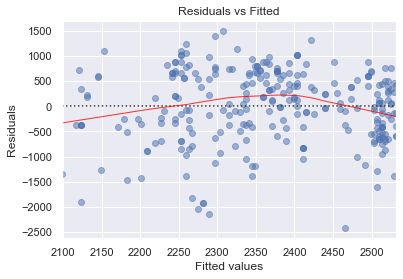

In [80]:
residualplot(wbpinemodel)

We can attempt a weak transformation with square root of our data

In [25]:
elevsqrt = wbpine['elevation'].apply(lambda x: x ** (1/2))
elevsqrt.dropna()

0      27.531800
1      41.737274
2      53.272882
3      41.761226
4      49.598387
         ...    
266    49.061186
267    44.102154
268    46.206060
269    44.022721
270    54.332311
Name: elevation, Length: 271, dtype: float64

4.42853700586473e-22


(array([ 1.,  3.,  3.,  3.,  5., 18., 55., 60., 96., 27.]),
 array([ 6.244998  , 11.79220785, 17.3394177 , 22.88662755, 28.4338374 ,
        33.98104725, 39.5282571 , 45.07546695, 50.6226768 , 56.16988665,
        61.7170965 ]),
 <BarContainer object of 10 artists>)

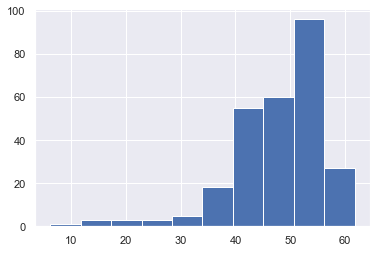

In [84]:
k2, p = normaltest(elevsqrt)
print(p)
plt.hist(elevsqrt)

In [26]:
wbpine['elevation sqrt'] = elevsqrt
wbpine

,decimalLatitude,decimalLongitude,elevation,eventDate,year,elevation sqrt
0,46.033730,-121.492740,758,1892-08-03T00:00:00,1892,27.531800
1,45.500000,-111.330000,1742,1897-07-28T00:00:00,1897,41.737274
2,37.843810,-119.421830,2838,1898-08-07T00:00:00,1898,53.272882
3,41.369300,-122.349800,1744,1899-08-01T00:00:00,1899,41.761226
4,41.316600,-122.486700,2460,1899-08-01T00:00:00,1899,49.598387
...,...,...,...,...,...,...
266,44.282600,-118.707330,2407,2010-07-16T00:00:00,2010,49.061186
267,43.706387,-121.235712,1945,2010-07-16T11:51:00,2010,44.102154
268,44.575610,-118.625310,2135,2010-07-17T00:00:00,2010,46.206060
269,44.332403,-118.807523,1938,2010-07-18T00:00:00,2010,44.022721


Perform regression on the transformed data.

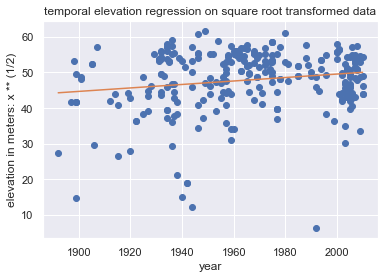

In [86]:
def elevsqrtreg(df):
    x = df['year']
    plt.plot(df['year'], df['elevation sqrt'], 'o')
    m, b = np.polyfit(df['year'], df['elevation sqrt'], 1)
    plt.title('temporal elevation regression on square root transformed data')
    plt.xlabel('year')
    plt.ylabel('elevation in meters: x ** (1/2)')
    return plt.plot(x, m*x+b)

elevsqrtreg(wbpine)

In [37]:
y = wbpine['elevation sqrt']
x = wbpine['year']


wbpinemodelsqrt = sm.ols('y~x', data=wbpine).fit()
print( wbpinemodelsqrt.summary() )

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     8.305
Date:                Fri, 13 Nov 2020   Prob (F-statistic):            0.00427
Time:                        13:44:41   Log-Likelihood:                -966.90
No. Observations:                 271   AIC:                             1938.
Df Residuals:                     269   BIC:                             1945.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -47.7535     33.187     -1.439      0.1

Run a test to detect heteroscedasticity and the findings are not significant.

In [38]:
from statsmodels.stats.diagnostic import het_white

white_testsqrt = het_white(wbpinemodelsqrt.resid,  wbpinemodelsqrt.model.exog)
white_testsqrt

(5.277520743377868, 0.0714497858587639, 2.661377319642068, 0.07169793846537735)

Visually inspect the residuals and determine the curve is somewhat flattened.

<AxesSubplot:title={'center':'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

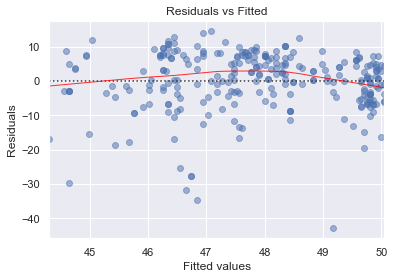

In [88]:
residualplot(wbpinemodelsqrt)

Run regression on the latitude data:

Average latitude in 1892: 40.713107163478746 
Average latitude in 2010: 42.9176238495087 


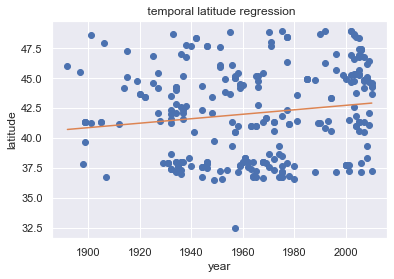

In [89]:
latreg(wbpine)

In [90]:
stats.linregress(x= wbpine['year'], y = wbpine['decimalLatitude'])

LinregressResult(slope=0.018682344796864373, intercept=5.366110807811303, rvalue=0.1521911421396471, pvalue=0.012126877102004347, stderr=0.007397366014560263)

                            OLS Regression Results                            
Dep. Variable:                     yl   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     6.378
Date:                Fri, 13 Nov 2020   Prob (F-statistic):             0.0121
Time:                        13:49:28   Log-Likelihood:                -743.26
No. Observations:                 271   AIC:                             1491.
Df Residuals:                     269   BIC:                             1498.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3661     14.540      0.369      0.7

,0,1
Intercept,-23.260944,33.993166
xl,0.004118,0.033246


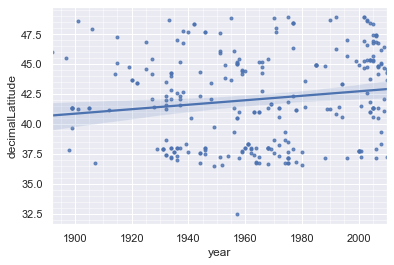

In [41]:
import seaborn as sns
import matplotlib as mpl

sns.set(style="darkgrid")  
scatter_kws={"s": 1}

fig, ax = plt.subplots(1, 1)


sns.regplot(x = 'year', y ='decimalLatitude', data=wbpine, marker = '.', ci=95)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

yl=wbpine['decimalLatitude']
xl=wbpine['year']
import statsmodels.formula.api as sm
wbpinemodellat = sm.ols('yl~xl', data=wbpine).fit()
print( wbpinemodellat.summary() )
wbpinemodellat.conf_int()

Visual inspection of residuals reveals another bow-shaped curve and one could opt to perform another transformation.  Although heteroscedasticity test returns insignificant.  For the time being we will move on to the next regression.

<AxesSubplot:title={'center':'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

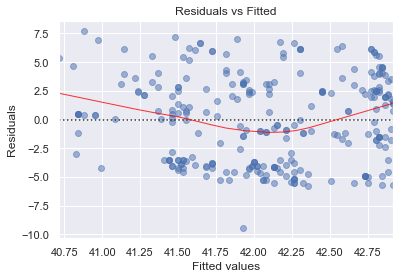

In [92]:
residualplot(wbpinemodellat)

In [42]:
from statsmodels.stats.diagnostic import het_white

white_testsqrt = het_white(wbpinemodelsqrt.resid,  wbpinemodelsqrt.model.exog)
white_testsqrt

(5.277520743377868, 0.0714497858587639, 2.661377319642068, 0.07169793846537735)

Regression of elevation on latitude:

Average elevation in Sierra Nevadas(37 degrees of latitude): 2989.4288356814277 meters
Average elevation in Cascades(47 degrees of latitude): 1766.5695797003218 meters
Average change per degree of latitude: -122.2859255981106 meters


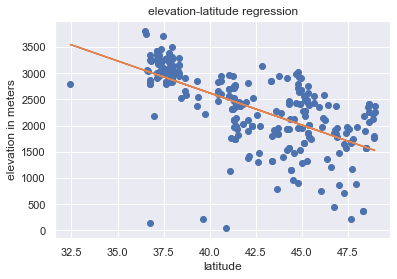

In [93]:
elevlatreg(wbpine)

There are multiple ways to calculate effect size from the summary results table.  One can do 2 * (t-statistic)/ sqrt(df residuals) to obtain Cohen's d.   One can also used the R-squared value to derive Cohen's f, another effect size measure where .1 ** 2 , .25 ** 2,  .4 ** 2 = small, medium,large effect sizes.
r squared/ 1-r squared = f squared.  One can also calculate cohen's d from the r squared, d = sqrt(4r ** 2/ 1 - r ** 2).  An r squared of .01, .059, .138 is equivalent to effect size .2, .5, .8.  

Create a function that will return a pvalue and effect size for a given regression and run on the elevation-latitude regression for the Whitebark Pine.

In [159]:
import statsmodels.formula.api as sm
def pval_eff(df, x, y): 
    model = sm.ols('y~x', data=df).fit()
    print ('P value for regression:  {}'.format(model.pvalues.x))
    print ('Effect size for regression: {}'.format( ( (4*model.rsquared) / (1 - model.rsquared) ) ** (1/2) ))
pval_eff(wbpine, wbpine.decimalLatitude, wbpine.elevation)

P value for regression:  5.385153921929066e-33
Effect size for regression: 1.6785266126037948


The Whitebark Pine is a high-elevation conifer, often found at the treeline or above it in the form of krummholz ("crooked timber"), as the preceding regression indicates.


Pacific Yew (taxus brevifolia) analysis:

In [95]:
paciyew = pd.read_csv('Desktop/biodata/0079777-200613084148143 - 0079777-200613084148143.csv')

In [96]:
paciyew

,species,locality,stateProvince,decimalLatitude,decimalLongitude,eventDate,year
0,Taxus brevifolia,Weott,California,40.351806,-123.923694,1957-08-21T00:00:00,1957
1,Taxus brevifolia,2 mi N of Easton,Washington,47.266011,-121.178979,1915-07-31T00:00:00,1915
2,Taxus brevifolia,Wimer,Oregon,42.538732,-123.148943,1893-04-03T00:00:00,1893
3,Taxus brevifolia,Newberg,Oregon,45.300118,-122.973156,1940-10-16T00:00:00,1940
4,Taxus brevifolia,near Bridgeville,NaN,40.500000,-123.800000,1933-03-19T00:00:00,1933
...,...,...,...,...,...,...,...
371,Taxus brevifolia,Fairview Mountain; at lookout on top.,Oregon,43.585800,-122.652700,1935-06-27T00:00:00,1935
372,Taxus brevifolia,"Belknap Ranch, McKenzie River.",Oregon,43.963500,-122.145300,1936-08-03T00:00:00,1936
373,Taxus brevifolia,Breitenbush Springs.,Oregon,44.783100,-121.977800,1936-07-23T00:00:00,1936
374,Taxus brevifolia,Fall Creek.,Oregon,43.959700,-122.819200,1932-05-17T00:00:00,1932


In [97]:
paciyew = paciyew.sort_values(by='eventDate')


In [98]:
paciyew = paciyew.reset_index(drop=True)

In [99]:
elevation(paciyew)

,species,locality,stateProvince,decimalLatitude,decimalLongitude,eventDate,year,elevation
0,Taxus brevifolia,Seattle. lake washington.,Washington,47.606390,-122.330830,1892-05-06T00:00:00,1892,82
1,Taxus brevifolia,Orcas Island; East Sound.,Washington,48.692500,-122.904167,1892-06-22T00:00:00,1892,11
2,Taxus brevifolia,NaN,NaN,48.300000,-116.520000,1892-08-08T00:00:00,1892,624
3,Taxus brevifolia,NaN,Oregon,42.432149,-122.728431,1893-04-03T00:00:00,1893,573
4,Taxus brevifolia,Wimer,Oregon,42.538732,-123.148943,1893-04-03T00:00:00,1893,348
...,...,...,...,...,...,...,...,...
371,Taxus brevifolia,"Ewing Island. Long, narrow island off northea...",Washington,48.764550,-122.880930,2009-09-24T00:00:00,2009,0
372,Taxus brevifolia,Along Wheatfield Fork of Gualala River just so...,California,38.668611,-123.329722,2010-06-21T00:00:00,2010,107
373,Taxus brevifolia,19 road miles south of the Forks-of-the-Salmon...,California,41.175833,-123.361389,2010-07-04T00:00:00,2010,1198
374,Taxus brevifolia,~6 road miles south of the Forks-of-the-Salmon...,California,41.237500,-123.321667,2010-07-04T00:00:00,2010,886


Average elevation in 1892: 706.0695530220942 meters
Average elevation in 2010: 884.2845809116552 meters
Change of 178.21502788956104 meters


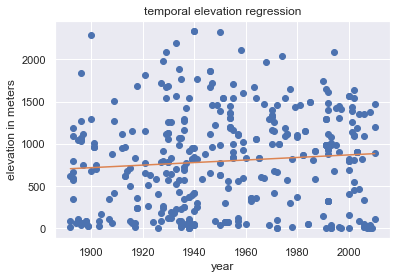

In [100]:
elevationreg(paciyew)

There's been an upward rise of approx. 180 m over the observation period.

In [160]:
pval_eff(paciyew, paciyew.year,paciyew.elevation)

P value for regression:  0.08239285125529659
Effect size for regression: 0.18011658293084923


Average latitude in 1892: 44.25986852545504 
Average latitude in 2010: 44.14140244124979 


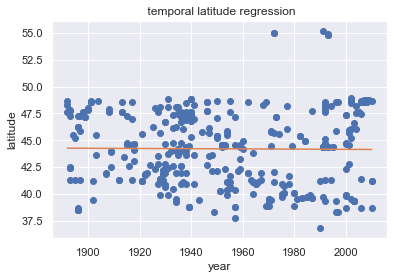

In [101]:
latreg(paciyew)

In [162]:
pval_eff(paciyew,paciyew.year,paciyew.decimalLatitude)

P value for regression:  0.8498611109013823
Effect size for regression: 0.019590049228777707


The latitude has remained largely static.

There are a few outliers on the preceding chart that one may investigate.  They belong to a population in Alaska.

In [99]:
sorted_dfyewyr.loc[sorted_dfyewyr['decimalLatitude'] >= 50]


,species,locality,stateProvince,decimalLatitude,decimalLongitude,eventDate,year
253,Taxus brevifolia,"Dog I., 40 km SSE of Ketchikan",Alaska,54.98,-131.31,1972-07-24T00:00:00,1972
254,Taxus brevifolia,"Dog I., 40 km SSE of Ketchikan",Alaska,54.98,-131.31,1972-07-24T00:00:00,1972
297,Taxus brevifolia,"Revillagegedo I., Alava Bay, 1 mile SW of Alav...",Alaska,55.21,-131.11,1991-12-29T00:00:00,1991
311,Taxus brevifolia,"Head of Nakat Inlet, on fish corral island",Alaska,54.94,-130.74,1993-07-07T00:00:00,1993
312,Taxus brevifolia,"Prince of Wales Island, Kendrick Bay, S side o...",Alaska,54.85,-132.00,1993-08-12T00:00:00,1993
313,Taxus brevifolia,"Prince of Wales Island, McLean Arm, N shore of...",Alaska,54.81,-132.06,1993-08-13T00:00:00,1993


Oregon Oak (quercus garryana) analysis:


In [103]:
oroak = pd.read_csv('Desktop/biodata/0080246-200613084148143 - 0080246-200613084148143.csv')

In [104]:
oroak

,species,infraspecificEpithet,locality,stateProvince,decimalLatitude,decimalLongitude,eventDate,year
0,Quercus garryana,NaN,San Juan Island,Washington,48.540932,-123.086016,1925-08-18T00:00:00,1925
1,Quercus garryana,NaN,Yolo County; UC Davis Arboretum; Section: Shie...,California,38.529444,-121.765000,2009-10-08T00:00:00,2009
2,Quercus garryana,breweri,Yolo County; UC Davis Arboretum; Section: Shie...,California,38.529167,-121.765000,2009-10-08T00:00:00,2009
3,Quercus garryana,NaN,Josephine Co.: Cave Junction. Eight Dollar Mou...,Oregon,42.250000,-123.683333,2006-07-26T00:00:00,2006
4,Quercus garryana,breweri,Yolo County; UC Davis Arboretum; Section: Cali...,California,38.534444,-121.750556,2009-11-05T00:00:00,2009
...,...,...,...,...,...,...,...,...
668,Quercus garryana,garryana,Rowena.,Oregon,45.672500,-121.267200,1932-04-24T00:00:00,1932
669,Quercus garryana,garryana,"Rebel Rock, S. Fk. McKenzie River.",Oregon,44.006500,-122.035800,1965-06-30T00:00:00,1965
670,Quercus garryana,breweri,on blocks of andesite by road to Musick Mine; ...,Oregon,43.579300,-122.657500,1965-07-09T00:00:00,1965
671,Quercus garryana,garryana,"Castle Rock, McKenzie River Region.",Oregon,44.149900,-122.213300,1967-06-28T00:00:00,1967


In [105]:
oroak = oroak.sort_values(by='eventDate')


In [106]:
oroak = oroak.reset_index(drop=True)

In [107]:
elevation(oroak)

,species,infraspecificEpithet,locality,stateProvince,decimalLatitude,decimalLongitude,eventDate,year,elevation
0,Quercus garryana,NaN,Fort Simcoe; Yakima Indian Reservation.,Washington,46.602220,-120.504720,1892-07-18T00:00:00,1892,325
1,Quercus garryana,NaN,NaN,California,38.419810,-120.824550,1893-09-10T00:00:00,1893,292
2,Quercus garryana,NaN,NaN,California,39.219060,-121.061060,1893-09-10T00:00:00,1893,740
3,Quercus garryana,NaN,NaN,California,39.936050,-122.064550,1894-09-01T00:00:00,1894,66
4,Quercus garryana,breweri,"Walker Creek, Dead Indian road, west slope Cas...",Oregon,42.304100,-122.970300,1895-06-14T00:00:00,1895,560
...,...,...,...,...,...,...,...,...,...
668,Quercus garryana,NaN,NaN,California,41.008204,-121.642236,2010-08-02T00:00:00,2010,910
669,Quercus garryana,NaN,Lebanon,Oregon,44.468199,-122.881448,2010-08-09T00:00:00,2010,234
670,Quercus garryana,garryana,High North Coast Ranges. 0.8 km northeast of H...,California,39.618611,-122.945000,2010-09-04T00:00:00,2010,1885
671,Quercus garryana,breweri,High North Coast Ranges. 0.8 km northeast of H...,California,39.618611,-122.945000,2010-09-04T00:00:00,2010,1885


Average elevation in 1892: 625.9534425736047 meters
Average elevation in 2010: 783.9556921916669 meters
Change of 158.00224961806225 meters


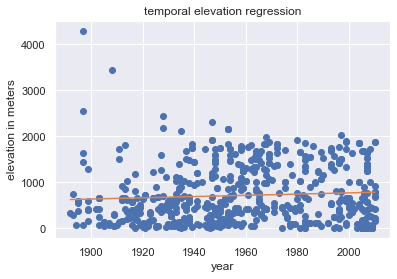

In [108]:
elevationreg(oroak)

In [163]:
pval_eff(oroak, oroak.year, oroak.elevation)

P value for regression:  0.07176016886439943
Effect size for regression: 0.13924570152344934


Average latitude in 1892: 41.2534464413205 
Average latitude in 2010: 40.74986078387238 


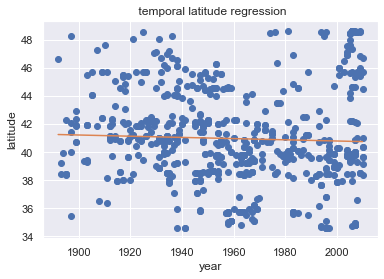

In [109]:
latreg(oroak)

A southward shift of approx .5 degrees of latitude.

In [164]:
pval_eff(oroak,oroak.year,oroak.decimalLatitude)

P value for regression:  0.302627019682709
Effect size for regression: 0.07964964491588199


Average elevation in Sierra Nevadas(37 degrees of latitude): 1018.7908319564926 meters
Average elevation in Cascades(47 degrees of latitude): 257.93920480831275 meters
Average change per degree of latitude: -76.08516271481798 meters


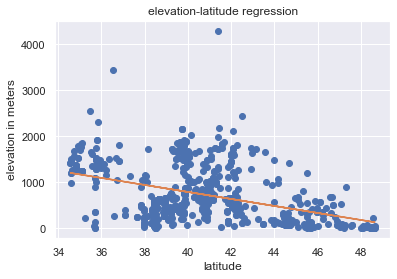

In [110]:
elevlatreg(oroak)

An average decrease of approx. 76 m in elevation for every degree of latitude as one heads north.

One can also run a time series analysis on the data which will separate out seasonal cycles and residual noise to obtain a more nuanced picture of any trend.

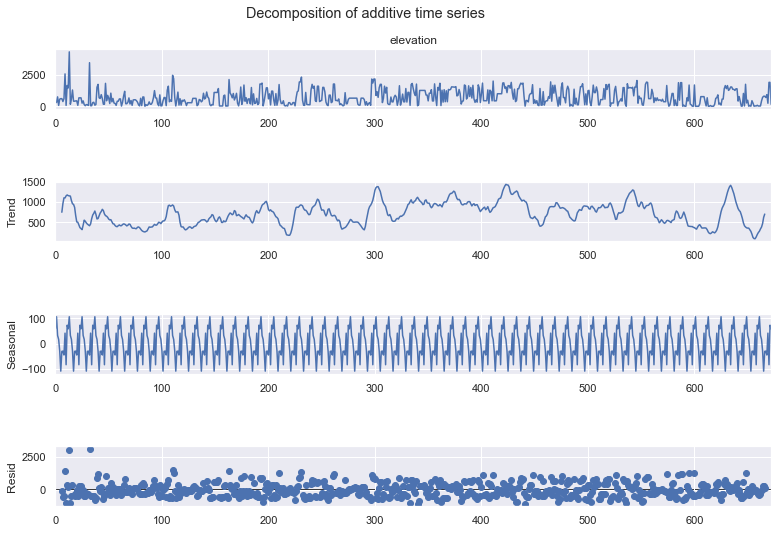

In [114]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
#df_oakelevts = df_oakelev.set_index('count')
#df_oakelevts.sort_index(inplace=True)
oroak.index.inferred_freq = 'M'
decomposition_add = sm.tsa.seasonal_decompose(oroak['elevation'], model='additive')
fig = decomposition_add.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of additive time series')
plt.show()

Obtain a date for any particular point of interest.

In [115]:
oroak['eventDate'][300]

'1953-08-27T00:00:00'

Import a chart of global temperature rise.

In [116]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://static01.nyt.com/images/2020/04/23/learning/GlobalTemp2019GraphLN/GlobalTemp2019GraphLN-superJumbo.png")

Incense Cedar (calocedrus decurrens) analysis:

In [118]:
import pandas as pd
incdr = pd.read_csv('Desktop/0081316-200613084148143 - 0081316-200613084148143.csv')

In [119]:
incdr = incdr.sort_values(by='eventDate')


In [120]:
incdr = incdr.reset_index(drop=True)

In [122]:
elevation(incdr)

,genus,species,infraspecificEpithet,scientificName,locality,stateProvince,decimalLatitude,decimalLongitude,eventDate,year,taxonKey,elevation
0,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,San Bernardino Mountain,California,34.131510,-116.956600,1892-06-05T00:00:00,1892,2683936,2053
1,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,Strawberry Valley,California,36.196073,-121.598554,1892-07-01T00:00:00,1892,2683936,836
2,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,Nevada County,California,39.168330,-121.183500,1892-08-01T00:00:00,1892,2683936,634
3,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,No locality information available,Oregon,42.411782,-122.675797,1893-01-14T00:00:00,1893,2683936,799
4,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,Wimer,Oregon,42.538732,-123.148943,1893-06-14T00:00:00,1893,2683936,348
...,...,...,...,...,...,...,...,...,...,...,...,...
611,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,"San Gabriel Mountains: Big Cienaga, north of C...",California,34.336670,-117.831390,2010-09-09T00:00:00,2010,2683936,1987
612,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,"Big Cienaga, north of Crystal Lake Campground,...",California,34.336670,-117.831390,2010-09-09T00:00:00,2010,2683936,1987
613,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,"Big Cienega, north of Crystal Lake Campground,...",California,34.336670,-117.831390,2010-09-09T00:00:00,2010,2683936,1987
614,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,"Crystal Lake, within 100 m of shoreline",California,34.318890,-117.846940,2010-09-13T00:00:00,2010,2683936,1692


Average elevation in 1892: 1160.2651227440713 meters
Average elevation in 2010: 1336.3521407238798 meters
Change of 176.08701797980848 meters


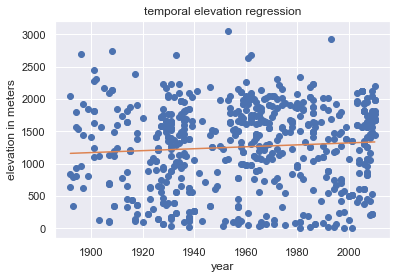

In [123]:
elevationreg(incdr)

In [165]:
pval_eff(incdr,incdr.year,incdr.elevation)

P value for regression:  0.06194006618515696
Effect size for regression: 0.150945363344494


Average latitude in 1892: 39.91430468558922 
Average latitude in 2010: 37.42074715637242 


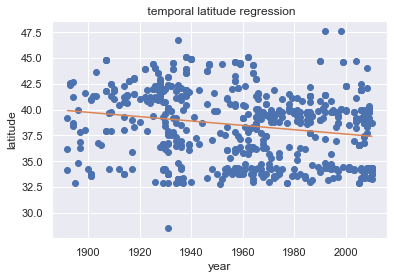

In [124]:
latreg(incdr)

In [166]:
pval_eff(incdr,incdr.year,incdr.decimalLatitude)

P value for regression:  9.350572315798341e-07
Effect size for regression: 0.3999612682545673


Average elevation in Sierra Nevadas(37 degrees of latitude): 1371.0959408810395 meters
Average elevation in Cascades(47 degrees of latitude): 630.7415015900879 meters
Average change per degree of latitude: -74.03544392909517 meters


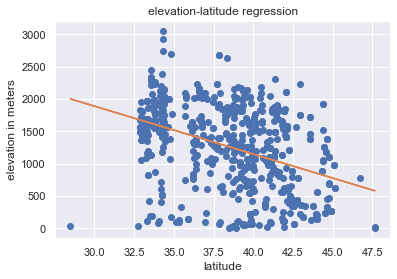

In [125]:
elevlatreg(incdr)

Thus far the analysis has been performed through proxies of temperature change (altitude, latitude) and here is an attempt at a more direct one.  The USDA utilizes a Plant Hardiness Zone system for mapping climatic conditions suitable for plant growth.  The zones are based on average annual winter extremes.



In [21]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://planthardiness.ars.usda.gov/PHZMWeb/images/72dpi/all_states_halfzones_title_legend_logos_72dpi.jpg")

Import the geopandas library in order to read in a file which contains coordinate data of the different zone regions for the continental US.

In [126]:
import geopandas as gpd

phzm = gpd.read_file('zip://Downloads/phm_us_shp.zip')

phzm

,ID,GRIDCODE,ZONE,geometry
0,1,14,7b: 5 to 10 F,"POLYGON ((-121.59583 49.07917, -121.59583 49.0..."
1,2,12,6b: -5 to 0 F,"POLYGON ((-121.54583 49.07917, -121.55417 49.0..."
2,3,12,6b: -5 to 0 F,"POLYGON ((-121.50417 49.07917, -121.51250 49.0..."
3,4,12,6b: -5 to 0 F,"POLYGON ((-121.47917 49.08750, -121.47083 49.0..."
4,5,11,6a: -10 to -5 F,"POLYGON ((-121.39583 49.07917, -121.39583 49.0..."
...,...,...,...,...
97156,97157,21,11a: 40 to 45 F,"POLYGON ((-81.02917 24.65417, -81.02917 24.662..."
97157,97158,21,11a: 40 to 45 F,"POLYGON ((-82.87083 24.54583, -82.92083 24.545..."
97158,97159,22,11b: 45 to 50 F,"POLYGON ((-82.00417 24.52917, -82.01250 24.529..."
97159,97160,22,11b: 45 to 50 F,"POLYGON ((-81.10417 24.78750, -81.10417 24.770..."


Convert the cedar pandas dataframe into a geopandas dataframe which will then allow for a spatial join, synchronizing the locations of the Incense Cedar occurrences with the appropriate locations from the Plant Hardiness Zone file, allowing one to  link a particular occurrence to a certain zone.

In [128]:
gdf_incdr = gpd.GeoDataFrame(incdr,   geometry=gpd.points_from_xy(incdr.decimalLongitude, incdr.decimalLatitude))# 3 - Neighbourhoods
gdf_incdr.crs = "EPSG:4269"
sjoined_cdr = gpd.sjoin(gdf_incdr, phzm)
sjoined_cdr

,genus,species,infraspecificEpithet,scientificName,locality,stateProvince,decimalLatitude,decimalLongitude,eventDate,year,taxonKey,elevation,geometry,index_right,ID,GRIDCODE,ZONE
0,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,San Bernardino Mountain,California,34.131510,-116.956600,1892-06-05T00:00:00,1892,2683936,2053,POINT (-116.95660 34.13151),90049,90050,14,7b: 5 to 10 F
394,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,San Bernardino Mountains; Mill Creek Canyon.,California,34.080000,-116.890000,1974-08-29T00:00:00,1974,2683936,1900,POINT (-116.89000 34.08000),90049,90050,14,7b: 5 to 10 F
528,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,"Barton Flats, along Hwy 38 near Jenks Lake, ab...",California,34.170830,-116.888610,2003-11-19T00:00:00,2003,2683936,1939,POINT (-116.88861 34.17083),90049,90050,14,7b: 5 to 10 F
606,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,SBNF: Upper Santa Ana River Watershed. Along S...,California,34.183190,-116.876000,2010-08-06T00:00:00,2010,2683936,1769,POINT (-116.87600 34.18319),90049,90050,14,7b: 5 to 10 F
1,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,Strawberry Valley,California,36.196073,-121.598554,1892-07-01T00:00:00,1892,2683936,836,POINT (-121.59855 36.19607),85472,85473,17,9a: 20 to 25 F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,"Highgrade Road 4.4 mi N of Fort Bidwell, N end...",California,41.915950,-120.170300,2006-08-04T00:00:00,2006,2683936,1821,POINT (-120.17030 41.91595),43574,43575,11,6a: -10 to -5 F
549,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,"Fort Bidwell, ca 4.4 mi N along Highgrade Rd",California,41.915950,-120.170290,2006-08-04T00:00:00,2006,2683936,1821,POINT (-120.17029 41.91595),43574,43575,11,6a: -10 to -5 F
551,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,Along Highgrade Road ca. 4.4 miles north of Fo...,California,41.915950,-120.170290,2006-08-04T00:00:00,2006,2683936,1821,POINT (-120.17029 41.91595),43574,43575,11,6a: -10 to -5 F
571,Calocedrus,Calocedrus decurrens,NaN,Calocedrus decurrens (Torr.) Florin,NaN,California,36.793270,-118.640865,2007-07-24T10:54:00,2007,2683936,2017,POINT (-118.64086 36.79327),76617,76618,14,7b: 5 to 10 F


The zones are convertible to a gridcode, running from 1 to 26 with 1 being the coldest and 26, the most tropical.

In [129]:
sjoined_cdr = sjoined_cdr.sort_values(by='eventDate')
sjoined_cdr = sjoined_cdr.reset_index(drop=True)
#tempcdr = ['GRIDCODE']
#tempcdr = pd.DataFrame(tempcdr)
#tempcdr['count'] = tempcdr.index
#tempcdr

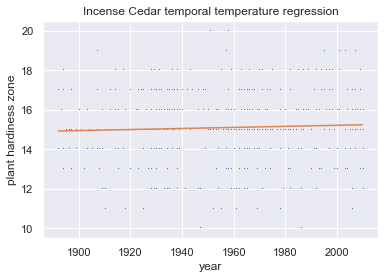

In [131]:
import matplotlib.pyplot as plt
import numpy as np
sjoined_cdr = sjoined_cdr.astype({"year": float, "GRIDCODE": float})


x = sjoined_cdr['year']
plt.plot(sjoined_cdr['year'], sjoined_cdr['GRIDCODE'], ',')
m, b = np.polyfit(sjoined_cdr['year'], sjoined_cdr['GRIDCODE'], 1)
plt.title('Incense Cedar temporal temperature regression')
plt.xlabel('year')
plt.ylabel('plant hardiness zone')
plt.plot(x, m*x+b)

Run a regression using the seaborn library with a translucent 95% confidence interval shading.

<AxesSubplot:xlabel='year', ylabel='GRIDCODE'>

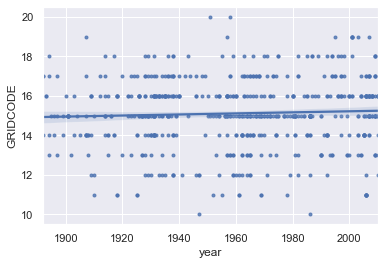

In [132]:
import seaborn as sns
sns.regplot(x = 'year', y ='GRIDCODE', data=sjoined_cdr, marker = '.')

In [133]:
from scipy import stats
stats.linregress(x= sjoined_cdr['year'], y = sjoined_cdr['GRIDCODE'])

LinregressResult(slope=0.002678731768494431, intercept=9.85938826683627, rvalue=0.0511699714887761, pvalue=0.20470629448910876, stderr=0.00210989358198227)

In [167]:
pval_eff(sjoined_cdr,sjoined_cdr.year,sjoined_cdr.GRIDCODE)

P value for regression:  0.2047062944891109
Effect size for regression: 0.1024741883754941


The p value for the temperature regression is not statistically significant (< .05) and thus one can't reject a null hypothesis.

In the final analysis, the results differ between species.  Certain species like the Whitebark Pine seem to show an unambiguous preference for colder locations, whereas the Mountain Dogwood results are more confounded.  The remaining three species did not generate statistically significant results.